In [1]:
import pandas as pd
import numpy as np

from dmarket.environments import SingleAgentTrainingEnv
from dmarket.info_settings import BlackBoxSetting
from dmarket.engine import MarketEngine

from Q_Learn import QAgent, SpecialRandomAgent

In [2]:
import matplotlib.pyplot as plt
import time

In [3]:
seller_res = 100
buyer_res = 200

fixed_agents = [
   # UniformRandomAgent('seller', 90),
    SpecialRandomAgent('seller', seller_res),
    SpecialRandomAgent('seller', seller_res),
    SpecialRandomAgent('seller', seller_res),
    SpecialRandomAgent('seller', seller_res),
    SpecialRandomAgent('buyer', buyer_res),
    SpecialRandomAgent('buyer', buyer_res),
    SpecialRandomAgent('buyer', buyer_res),
    SpecialRandomAgent('buyer', buyer_res),
    SpecialRandomAgent('buyer', buyer_res),
]

#choose train = True for training
rl_agent = QAgent('seller', seller_res, 'zeki', train = True)
setting = BlackBoxSetting()
#rl_agent.q_table = np.loadtxt('Q_table.csv') # comment this one for training

def get_env(rl_agent, fixed_agents, setting):
    return SingleAgentTrainingEnv(rl_agent, fixed_agents, setting)

In [21]:
def get_reward(agent, deals):
    if not agent.name in deals:
        return 0

    deal_price = deals[agent.name]
    if agent.role == 'buyer':
        return agent.reservation_price - deal_price
    else:
        return deal_price - agent.reservation_price

def play_games(agents, setting, n_games=100, max_steps=10):
    buyer_ids =  [
        agent.name
        for agent in agents
        if agent.role == 'buyer'
    ]
    seller_ids =  [
        agent.name
        for agent in agents
        if agent.role == 'seller'
    ]
    ids = set(buyer_ids + seller_ids)
    market = MarketEngine(buyer_ids, seller_ids, max_steps=max_steps)
    
    rewards = pd.DataFrame(0, index=np.arange(n_games), columns=ids)
    for game_idx in range(n_games):
        while market.done != ids:
            observations = setting.get_states(ids, market)
            unmatched_agents = [
                agent for agent in agents
                if agent.name not in market.done
            ]
            offers = {
                agent.name: agent.get_offer(observations[agent.name])
                for agent in unmatched_agents
            }
            deals = market.step(offers)
            for agent in unmatched_agents:
                rewards[agent.name][game_idx] = get_reward(agent, deals)
            rl_agent.update_table(rewards['zeki'][game_idx]) # this should be uncommented for training
        market.reset()
    return rewards

In [14]:
# play_games(fixed_agents + [rl_agent], setting, 10) # to see each round individually

,Spec_B200_a90e,Spec_S100_4e41,Spec_B200_0a7a,Spec_B200_9c64,Spec_S100_8a76,Spec_B200_b638,Spec_S100_adf7,Spec_B200_025a,Spec_S100_fea3,zeki
0,35,52,42,45,64,47,57,53,54,46
1,48,50,0,49,33,66,64,35,51,0
2,52,43,56,50,49,52,47,28,71,47
3,61,38,42,71,63,36,57,40,59,28
4,41,53,30,50,58,48,51,46,49,69
5,54,45,47,32,52,46,56,43,53,67
6,31,68,0,51,51,33,0,48,48,66
7,40,53,46,52,66,23,59,33,47,76
8,52,54,45,37,40,34,62,59,47,65
9,48,36,48,50,51,56,43,63,51,49


In [22]:
# measure time
start_time = time.time()
play_games(fixed_agents + [rl_agent], setting, n_games=500).describe()
# print the elapsed time
elapsed_time = time.time() - start_time
print("Time passed: " + str(int(elapsed_time)) + " seconds.")

Time passed: 1 seconds.


In [24]:
print(rl_agent.q_table)
np.savetxt('Q_table_profiling_new_env.csv', rl_agent.q_table)

[[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  1.           0.           7.722     ]
 [  1.6          0.           6.304     ]
 [ 16.312        5.4         10.426     ]
 [  2.8         18.976       27.9300464 ]
 [  1.2         11.0952      27.18314668]
 [ 26.13050815  52.34567373  35.08537574]
 [ 30.33209861  66.5511687   65.05298616]
 [ 39.47290664 100.10517598 162.27989573]
 [ 51.02988908 162.49526031 261.00783443]
 [ 21.41575632 150.41248394  89.74882006]
 [ 59.05770399 155.55014743 135.80046948]
 [ 96.87176043 174.4012609  221.16753536]
 [188.87750379 262.31420036 238.4264932 ]
 [286.51029006 243.60434361 326.7321995 ]
 [ 84.53506028 207.00741671  81.69729616]
 [167.05466391 159.52171267 139.80941879]
 [212.35128493 146.62131171 203.08143337]
 [265.64134526 203.46468693 247.1096243 ]
 [306.36333198 251.70899895 156.50213513]]


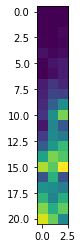

In [25]:
plt.imshow(rl_agent.q_table)